In [1]:
import os
import warnings
from pathlib import Path

import random
import pandas as pd
import patsy
import numpy as np
import ot
import seaborn as sns
import time

import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold as skmf
import sklearn.decomposition as skdc
import sklearn.metrics as skmr
from lxml import etree
from umap import UMAP

import condo

from combat import combat

this_file = os.path.realpath('__file__')
# data_path = os.path.join(Path(this_file).parent.parent, 'data')
data_path = 'data'

In [2]:
pheno = pd.read_csv(os.path.join(data_path, 'TCGA_GBM_and_LGG_SEX_LABELS.csv'), index_col=0)
expr = pd.read_csv(os.path.join(data_path, 'TCGA_GBM_and_LGG_SEX_PREPROCESSED_RNASEQ_EXPRESSION.csv'), index_col=0)
exprTranspose = expr.T

In [13]:
# # Combat
# start_time = time.time()
# mod = patsy.dmatrix("~ age + cancer", pheno, return_type="dataframe")
# exprTranspose_combat = combat(exprTranspose, pheno['batch'], mod, "age")
# expr_combat = exprTranspose_combat.T
# duration_combat = time.time() - start_time
# print(f"Combat time: {duration_combat}")

# Gaussian OT
start_time = time.time()
lder = condo.LinearAdapter(
    transform_type="location-scale",
)
lder.fit(
    expr[pheno.gender == 'female'].values, 
    expr[pheno.gender == 'male'].values,
)
expr_linear = lder.transform(expr.values)
duration_linear = time.time() - start_time
print(f"Gaussian OT time: {duration_linear}")
# expr_linear[np.where(pheno.gender == 'male')[0],:] = expr.values[np.where(pheno.gender == 'male')[0],:]

# MMD
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mmder = condo.MMDAdapter(
        transform_type="location-scale",
        optim_kwargs={"epochs": 10, "alpha": 1e-3, "beta": 0.999},
        verbose=0,
    )
    mmder.fit(
        expr[pheno.gender == 'female'].values, 
        expr[pheno.gender == 'male'].values,
    )
expr_mmd = mmder.transform(expr.values)
duration_mmd = time.time() - start_time
print(f"MMD time: {duration_mmd}")
# expr_mmd[np.where(pheno.gender == 'male')[0],:] = expr.values[np.where(pheno.gender == 'male')[0],:]

# Condo Linear ReverseKL
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_clinear = condo.ConDoAdapter(
        sampling="product",
        transform_type="location-scale",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0,
    )
    cder_clinear.fit(
        expr[pheno.gender == 'female'].values, 
        expr[pheno.gender == 'male'].values,
        pheno[pheno.gender == 'female'].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.gender == 'male'].result.values.reshape(-1, 1).astype(str),
    )
expr_clinear = cder_clinear.transform(expr.values)
duration_clinear = time.time() - start_time
print(f"ConDo Linear-ReverseKL time: {duration_clinear}")
# expr_clinear[np.where(pheno.gender == 'male')[0],:] = expr.values[np.where(pheno.gender == 'male')[0],:]

# Condo PoGMM
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_pogmm = condo.ConDoAdapter(
        sampling="product",
        transform_type="location-scale",
        model_type="pogmm",
        divergence="reverse",
        debug=False,
        verbose=0,
    )
    cder_pogmm.fit(
        expr[pheno.gender == 'female'].values, 
        expr[pheno.gender == 'male'].values,
        pheno[pheno.gender == 'female'].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.gender == 'male'].result.values.reshape(-1, 1).astype(str),
    )
expr_pogmm = cder_pogmm.transform(expr.values)
duration_pogmm = time.time() - start_time
print(f"ConDo PoGMM time: {duration_pogmm}")
# expr_pogmm[np.where(pheno.gender == 'male')[0],:] = expr.values[np.where(pheno.gender == 'male')[0],:]

# # ConDo GP
# start_time = time.time()
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     cder_cgp = condo.ConDoAdapter(
#         sampling="product",
#         transform_type="affine",
#         model_type="heteroscedastic-gp",
#         divergence="reverse",
#         debug=False,
#         verbose=0,
#     )
#     cder_cgp.fit(
#         expr[pheno.gender == 'female'].values, 
#         expr[pheno.gender == 'male'].values,
#         pheno[pheno.gender == 'female'].result.values.reshape(-1, 1).astype(str),
#         pheno[pheno.gender == 'male'].result.values.reshape(-1, 1).astype(str),
#     )
# expr_cgp = cder_cgp.transform(expr.values)
# duration_cgp = time.time() - start_time
# print(f"ConDo GP-ReverseKL time: {duration_cgp}")
# expr_cgp[np.where(pheno.gender == 'male')[0],:] = expr.values[np.where(pheno.gender == 'male')[0],:]

# ConDo MMD
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_mmd = condo.ConDoAdapter(
        sampling="product",
        transform_type="location-scale",
        model_type="empirical",
        divergence="mmd",
        optim_kwargs={"epochs": 10, "alpha": 1e-4, "beta": 0.999},
        debug=False,
        verbose=0,
    )
    cder_mmd.fit(
        expr[pheno.gender == 'female'].values, 
        expr[pheno.gender == 'male'].values,
        pheno[pheno.gender == 'female'].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.gender == 'male'].result.values.reshape(-1, 1).astype(str),
    )
expr_cmmd = cder_mmd.transform(expr.values)
duration_cmmd = time.time() - start_time
print(f"ConDo MMD: {duration_cmmd}")
# expr_cmmd[np.where(pheno.gender == 'male')[0],:] = expr.values[np.where(pheno.gender == 'male')[0],:]

Gaussian OT time: 14.069278001785278
MMD time: 185.55475616455078
ConDo Linear-ReverseKL time: 9.023776054382324
ConDo PoGMM time: 7.495832920074463
ConDo MMD: 299.06895637512207


In [ ]:
sns.set_context("talk")
dinfos = [
    (0, "Original", expr),
    #(1, "Combat", expr_combat),
    (1, "Gaussian OT", expr_linear),
    (2, "MMD", expr_mmd),
    (3, "ConDo Linear-ReverseKL", expr_clinear),
    (4, "ConDo PoGMM-ReverseKL", expr_pogmm),
    # (5, "ConDo GP-ReverseKL", expr_cgp),
    (5, "ConDo MMD", expr_cmmd),
]
fig = plt.figure(figsize=(5, 23), constrained_layout=True)
subfigs = fig.subfigures(nrows=len(dinfos), ncols=1)

for dix, dname, dset in dinfos:
    axes = subfigs[dix].subplots(nrows=1, ncols=3)
    sil_result = skmr.silhouette_score(dset, pheno.result, metric='euclidean')
    sil_batch = skmr.silhouette_score(dset, pheno.gender, metric='euclidean')
    db_result = skmr.davies_bouldin_score(dset, pheno.result)
    db_batch = skmr.davies_bouldin_score(dset, pheno.gender)
    dtitle = f"{dname}\n{db_batch:.2f} (batch), {db_result:.2f} (result)"
    # dtitle = f"{dname}\n{sil_batch:.2f} (batch), {sil_result:.2f} (result)"
    subfigs[dix].suptitle(dtitle);  

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsner = skmf.TSNE(n_components=2)
        tsne_embed = tsner.fit_transform(dset)
        tsne_data = pheno.copy()
        tsne_data["tsne 1"] = tsne_embed[:, 0]
        tsne_data["tsne 2"] = tsne_embed[:, 1]

    pcaer = skdc.PCA(n_components=2)
    pca_embed = pcaer.fit_transform(dset)
    pca_data = pheno.copy()
    pca_data["pc 1"] = pca_embed[:, 0]
    pca_data["pc 2"] = pca_embed[:, 1]       
    
    umaper = UMAP(n_components=2)
    umap_embed = umaper.fit_transform(dset)
    umap_data = pheno.copy()
    umap_data["umap 1"] = umap_embed[:, 0]
    umap_data["umap 2"] = umap_embed[:, 1]       
    sns.scatterplot(
        data=tsne_data, ax=axes[0],
        x="tsne 1", y="tsne 2", hue="gender", style="result", 
        palette=["red", "blue"], edgecolor="none", legend=False,
    )
    if dix < 0:
        leg = "auto"
    else:
        leg = False
    sns.scatterplot(
        data=pca_data, ax=axes[1],
        x="pc 1", y="pc 2", hue="gender", style="result", 
        palette=["red", "blue"], edgecolor="none", legend=leg);
    sns.scatterplot(
        data=umap_data, ax=axes[2],
        x="umap 1", y="umap 2", hue="gender", style="result", 
        palette=["red", "blue"], edgecolor="none", legend=leg,
    )
    """
    if dix == 0:
        plt.legend(
            loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=2,
        );
    """
    """
    #(_, max_x) = axes[1].get_xlim();
    #(_, max_x) = axes[1].get_xlim();

    axes[1].text(
        #np.max(pca_embed[:,0])*2.0, 0.5, 
        1.2, 0.5,
        f"Silhouette\nBatch:{sil_batch:.2f}\nOutcome:{sil_result:.2f}",
        transform = axes[1].transAxes); 
    """
    axes[0].set_xticks([]);
    axes[1].set_xticks([]);
    axes[2].set_xticks([]);
    axes[0].set_yticks([]);
    axes[1].set_yticks([]);
    axes[2].set_yticks([]);
    axes[0].set_xlabel(None);
    axes[1].set_xlabel(None);
    axes[2].set_xlabel(None);
    axes[0].set_ylabel(None);
    axes[1].set_ylabel(None);
    axes[2].set_ylabel(None);
# fig.savefig("figure-Bladderbatch-noconfounding.pdf", bbox_inches="tight")
fig.savefig("figure-TCGA-GENDER-FEMALE_MALE-noconfounding.pdf", bbox_inches="tight")

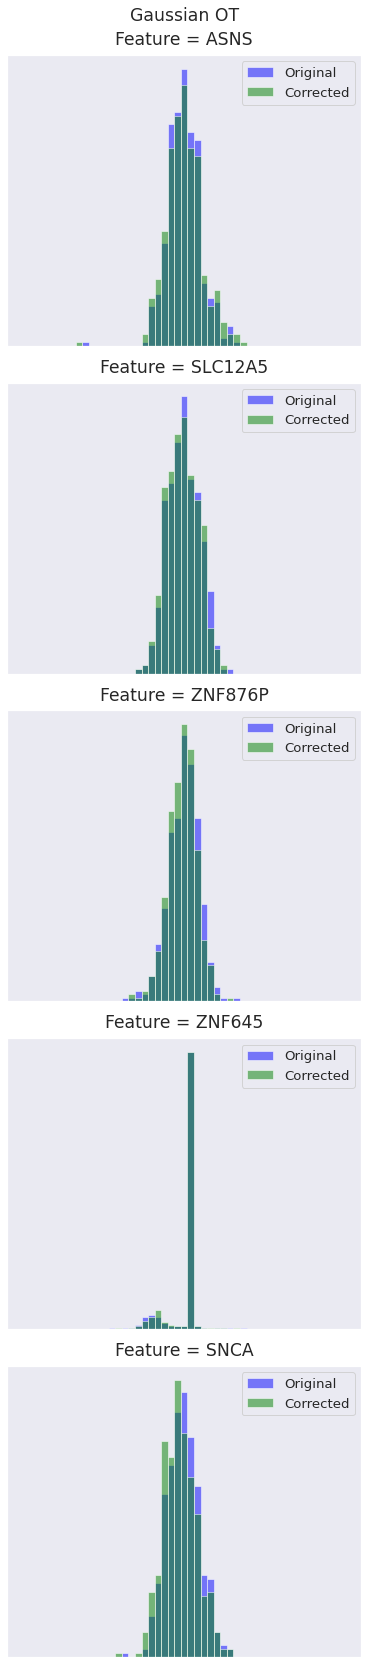

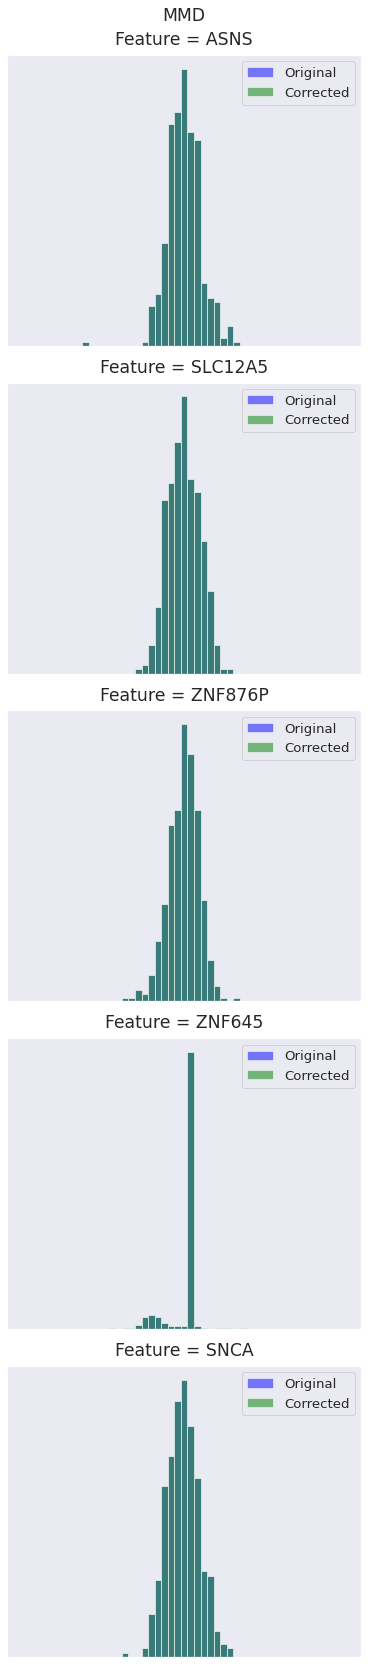

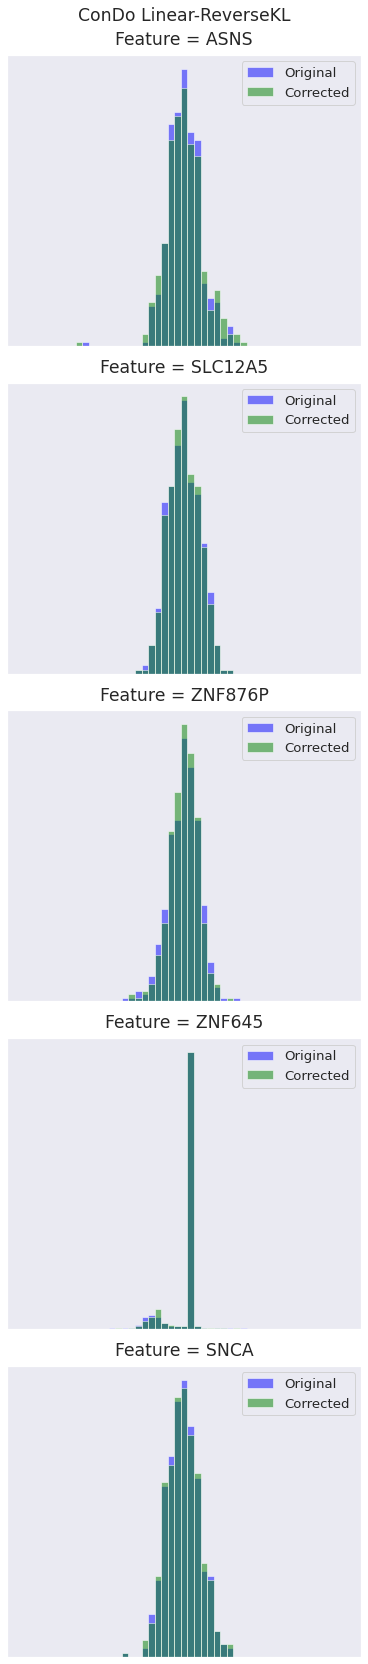

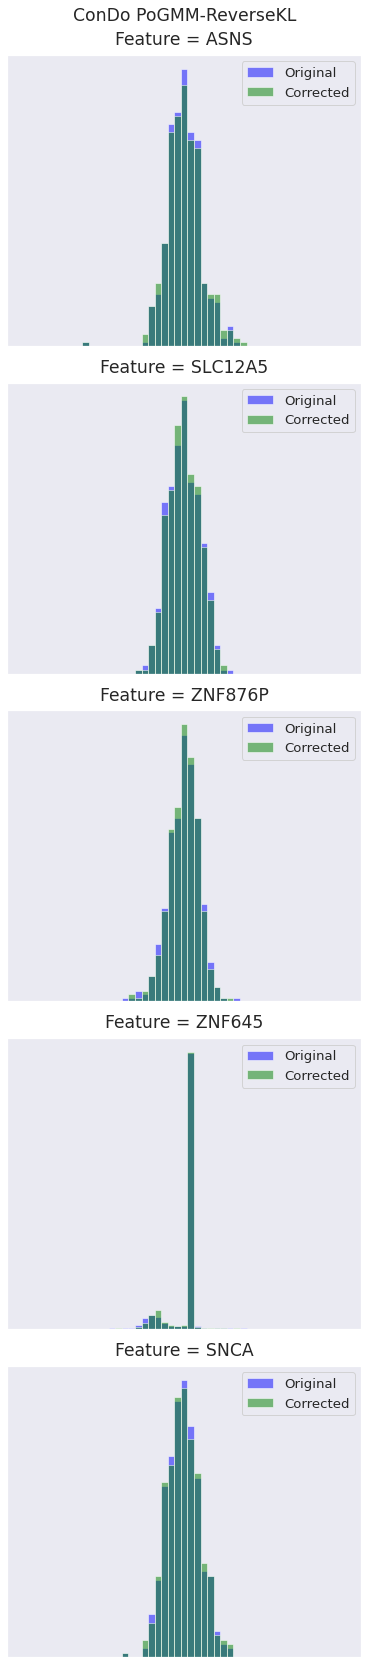

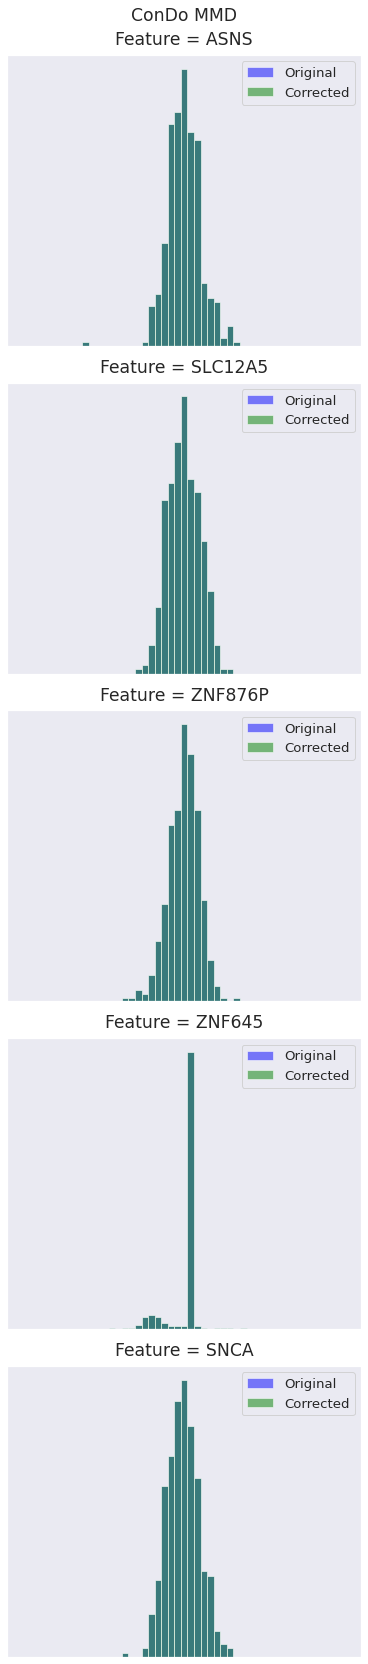

In [14]:
sns.set_context("talk")
sns.set(style="darkgrid", font_scale=1.2)

dinfos = [
    ("Gaussian OT", pd.DataFrame(expr_linear, columns=expr.columns, index=expr.index)),
    ("MMD", pd.DataFrame(expr_mmd, columns=expr.columns, index=expr.index)),
    ("ConDo Linear-ReverseKL", pd.DataFrame(expr_clinear, columns=expr.columns, index=expr.index)),
    ("ConDo PoGMM-ReverseKL", pd.DataFrame(expr_pogmm, columns=expr.columns, index=expr.index)),
    ("ConDo MMD", pd.DataFrame(expr_cmmd, columns=expr.columns, index=expr.index)),
]
num_feats = 5
feat_idxs = random.choices(expr.columns, k=num_feats)

for dname, dset in dinfos:
    fig = plt.figure(figsize=(num_feats, 23), constrained_layout=True)
    fig.suptitle(dname)
    subfigs = fig.subfigures(nrows=num_feats, ncols=1)
    for i, idx in enumerate(feat_idxs):
        axes = subfigs[i].subplots(nrows=1, ncols=1)
        dtitle = f"Feature = {idx}"
        subfigs[i].suptitle(dtitle);  

        bins = np.linspace(-10, 10, 50)

        axes.hist(expr[idx], bins, alpha=0.5, label='Original', color = "blue")
        axes.hist(dset[idx], bins, alpha=0.5, label='Corrected', color='green')
        axes.legend(loc='upper right')
        
        axes.set_xticks([]);
        axes.set_yticks([]);
        axes.set_xlabel(None);
        axes.set_ylabel(None);
    fig.savefig(f"figure-feat_dist-{dname}-TCGA-gender-noconfounding.pdf", bbox_inches="tight")